In [ ]:
#importing necessary packages
import requests
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import csv
import os
from dotenv import load_dotenv
import time
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import random
import tensorflow as tf
from sklearn.metrics import mean_squared_error

In [2]:
#setting seeds for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# META Cleaning

In [ ]:
#reading the meta data
meta_data = pd.read_csv('full_complete_datasets/META_raw_complete_data.csv')

print(meta_data.head())

         date  META_close  META_high  META_low  META_open  META_traded_volume  \
0  2012-05-18     38.2318      45.00     38.00      42.05           573576400   
1  2012-05-21     34.0300      36.66     33.00      36.53           168192700   
2  2012-05-22     31.0000      33.59     30.94      32.61           101786600   
3  2012-05-23     32.0000      32.50     31.36      31.37            73600000   
4  2012-05-24     33.0300      33.21     31.77      32.95            50237200   

   META_adjClose  META_adjLow  META_adjOpen  META_adj_traded_volume  ...  \
0      38.086917    37.855995     41.890647               573576400  ...   
1      33.901040    32.874943     36.391566               168192700  ...   
2      30.882522    30.822750     32.486421               101786600  ...   
3      31.878733    31.241158     31.251120                73600000  ...   
4      32.904829    31.649604     32.825133                50237200  ...   

   NVDA_traded_volume  NVDA_adjClose NVDA_adjLow NVDA_ad

In [4]:
#these columns just represents the company's symbol and currency labels and is not useful so we drop it
meta_data.drop(columns= ['symbol', 'CADUSD_label', 'KRWUSD_label', 'CNHUSD_label', 'GBPUSD_label', 'JPYUSD_label', 'EURUSD_label', 'CHFUSD_label', 'sector', 'exchange'], inplace=True)

In [5]:
#calculating the percentage of missing values for each column
missing_percentages = (meta_data.isnull().sum() / len(meta_data)) * 100

#only want to show the columns that have missing values
missing_percentages = missing_percentages[missing_percentages > 0]

#printing the columns with missing data
print(missing_percentages)

pe                                          0.663050
basicMaterialsChangesPercentage           100.000000
communicationServicesChangesPercentage     23.930078
consumerCyclicalChangesPercentage          23.930078
consumerDefensiveChangesPercentage         23.930078
                                             ...    
tema                                        0.120555
williams                                    0.120555
wma                                         0.120555
META_twitter_social_sentiment              98.101266
NVDA_twitter_social_sentiment              98.101266
Length: 113, dtype: float64


In [6]:
#checking duplicate rows
duplicates = meta_data.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

#showing the duplicate rows
print(meta_data[duplicates])


Number of duplicate rows: 50
            date  META_close  META_high  META_low  META_open  \
59    2012-08-10      21.807    21.8200   21.1300    21.4100   
61    2012-08-10      21.807    21.8200   21.1300    21.4100   
123   2012-11-08      19.990    20.7300   19.9800    20.5200   
124   2012-11-08      19.990    20.7300   19.9800    20.5200   
125   2012-11-08      19.990    20.7300   19.9800    20.5200   
186   2013-02-06      29.050    29.2900   28.6600    28.7400   
188   2013-02-06      29.050    29.2900   28.6600    28.7400   
252   2013-05-07      26.889    27.8500   26.8500    27.5500   
253   2013-05-07      26.889    27.8500   26.8500    27.5500   
316   2013-08-05      39.189    39.3200   38.2500    38.4300   
317   2013-08-05      39.189    39.3200   38.2500    38.4300   
318   2013-08-05      39.189    39.3200   38.2500    38.4300   
507   2014-05-02      60.460    61.8900   60.1800    61.3000   
508   2014-05-02      60.460    61.8900   60.1800    61.3000   
637   2014-

In [7]:
#dropping any duplicate rows
meta_data = meta_data.drop_duplicates()

In [8]:
#removing columns with large amounts of missing data (in this case columns with 75% missing data)
cols_to_remove = [col for col in meta_data.columns if meta_data[col].isnull().mean() * 100 >= 75]

#printing the columns to be removed
print("Columns removed due to more than 75% missing values:")
print(cols_to_remove)

#dropping columns
meta_data = meta_data.drop(columns=cols_to_remove)

Columns removed due to more than 75% missing values:
['basicMaterialsChangesPercentage', 'financialServicesChangesPercentage', 'META_twitter_social_sentiment', 'NVDA_twitter_social_sentiment']


In [9]:
#filling the columns with 1% or less missing data with the mode of their columns

#finding all the columns with very little missing data- less than 1% missing
vsmall_missing_cols = [col for col in meta_data.columns if meta_data[col].isnull().mean() * 100 <= 1]

#filling with the mode
for col in vsmall_missing_cols:
    meta_data[col].fillna(meta_data[col].mode()[0], inplace=True)

print(f"Filled missing values in {len(vsmall_missing_cols)} columns using mode.")

Filled missing values in 69 columns using mode.


C:\Users\mckay\AppData\Local\Temp\ipykernel_8788\262895265.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  meta_data[col].fillna(meta_data[col].mode()[0], inplace=True)
C:\Users\mckay\AppData\Local\Temp\ipykernel_8788\262895265.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

In [12]:
#converting date to time series
meta_data['date'] = pd.to_datetime(meta_data['date'])
meta_data.set_index('date', inplace=True)

#add 'year' and 'month' columns to use for averages
meta_data['year'] = meta_data.index.year
meta_data['month'] = meta_data.index.month

In [13]:
#filling the columns with changepercent or changesoercentage
changes_percent_cols = [col for col in meta_data.columns if 'changespercent' in col.lower() or 'changespercentage' in col.lower()]

# Apply rolling mean, then forward-fill and backward-fill as a backup
for col in changes_percent_cols:
    #using a rolling mean to fill as many of the NaNs as possible
    meta_data[col] = meta_data[col].rolling(window=7, min_periods=1).mean()
    #whatever the rolling mean can't fill- interpolate   
    meta_data[col] = meta_data[col].interpolate(method='linear', limit_direction='both')
    mask_nan = meta_data[col].isna()
    if meta_data[col].isna().sum() > 0:
        #fill remaining NaNs using the average for each year-month group if the rolling mean and interpolating can't fill gaps
        monthly_avg = meta_data.groupby(['year', 'month'])[col].transform('mean')
        meta_data[col] = meta_data[col].fillna(monthly_avg)
    meta_data[col] = meta_data[col].fillna(meta_data[col].mean())

print(f"All missing values in {len(changes_percent_cols)} columns have been filled.")

All missing values in 9 columns have been filled.


In [15]:
#cleaning the foreign exchange columns
currency_cols = [col for col in meta_data.columns if 'USD' in col]

#using rolling mean, interpolation and regular averages
for col in currency_cols:
    #start with filling with the rolling mean
    meta_data[col] = meta_data[col].rolling(window=5, min_periods=1).mean()
    #interpolating what the rolling mean can;t fill
    meta_data[col] = meta_data[col].interpolate(method='time')  
    mask_nan = meta_data[col].isna()
    missing_mask = meta_data[col].isna()
    if missing_mask.sum() > 0:
        #filling with a monthly average whatever is left
        monthly_avg = meta_data.groupby(['year', 'month'])[col].transform('mean')
        meta_data.loc[missing_mask, col] = monthly_avg[missing_mask]

    # Step 4: Final fallback — global average
    still_missing = meta_data[col].isna().sum()
    if still_missing > 0:
        print(f"→ {still_missing} values still missing. Filling with global mean.")
        meta_data[col].fillna(meta_data[col].mean(), inplace=True)


In [16]:
#checking the sentiment columns
meta_data['META_stock_news_sentiment'].unique()
meta_data['NVDA_stock_news_sentiment'].unique()
meta_data['META_press_release_sentiment'].unique()
meta_data['NVDA_press_release_sentiment'].unique()

array(['neutral', 'weakly_positive', 'weakly_negative',
       'strongly_positive', 'strongly_negative',
       "i'm sorry, but i cannot provide sentiment analysis for future dates such as november 16, 2023, as it falls beyond my training data which goes up to october 2023. my responses are based on patterns and information available up to that point and i can only generate predictions or extrapolations from existing knowledge rather than provide insights or data about future events.",
       "i'm sorry, but i cannot provide information or sentiment analysis for future events or hypothetical scenarios beyond my training data, which ends in october 2023.",
       "i'm sorry, but i am unable to provide real-time or future sentiment analysis on specific dates for specific companies.",
       "i'm sorry, but i cannot provide future or speculative information based on historical data.",
       "i'm sorry, but i can’t provide real-time or future information as my training only includes data 

In [17]:
#fixing the sentiment columns that did not get any informaiton from llm
#replacing values that are not useful as missing 
meta_data['META_stock_news_sentiment'][meta_data['META_stock_news_sentiment'].str.contains("i'm sorry, but i", case=False, na=False)] = np.nan
meta_data['NVDA_stock_news_sentiment'][meta_data['NVDA_stock_news_sentiment'].str.contains("i'm sorry, but i", case=False, na=False)] = np.nan


#creating an exclusion to avoid replacing these as missing
exclusion = ['neutral', 'weakly_positive', 'weakly_negative', 'strongly_positive',  'strongly_negative']

#filling values as missing excluding those in the exclusion list
meta_data['META_press_release_sentiment'] = meta_data['META_press_release_sentiment'].apply(
    lambda x: x if x in exclusion else np.nan
)
meta_data['NVDA_press_release_sentiment'] = meta_data['NVDA_press_release_sentiment'].apply(
    lambda x: x if x in exclusion else np.nan
)

print(meta_data['META_stock_news_sentiment'].unique())
print(meta_data['NVDA_stock_news_sentiment'].unique())
print(meta_data['META_press_release_sentiment'].unique())
print(meta_data['NVDA_press_release_sentiment'].unique())


['weakly_negative' 'strongly_negative' 'neutral' 'weakly_positive'
 'strongly_positive']
['neutral' 'weakly_negative' 'weakly_positive' 'strongly_positive'
 'strongly_negative']
['weakly_negative' 'neutral' 'strongly_negative' 'weakly_positive'
 'strongly_positive' nan]
['neutral' 'weakly_positive' 'weakly_negative' 'strongly_positive'
 'strongly_negative' nan]


C:\Users\mckay\AppData\Local\Temp\ipykernel_8788\820712349.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_data['META_stock_news_sentiment'][meta_data['META_stock_news_sentiment'].str.contains("i'm sorry, but i", case=False, na=False)] = np.nan
C:\Users\mckay\AppData\Local\Temp\ipykernel_8788\820712349.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_data['NVDA_stock_news_sentiment'][meta_data['NVDA_stock_news_sentiment'].str.contains("i'm sorry, but i", case=False, na=False)] = np.nan


In [ ]:
#filling missing values of META_press_release_statement with mode by each year and month
meta_data['META_press_release_sentiment']  = meta_data.groupby(['year', 'month'])['META_press_release_sentiment'].transform(lambda value: value.fillna(value.mode().iloc[0]))

#filling missing values of NVDA_press_release_sentiment with mode by each year and month
meta_data['NVDA_press_release_sentiment']  = meta_data.groupby(['year', 'month'])['NVDA_press_release_sentiment'].transform(lambda value: value.fillna(value.mode().iloc[0]))

In [24]:
#month2 was missing a large chunck of values in the begging dates
#compute correlation of all columns with 'month2'
correlations = meta_data.corr(numeric_only=True)['month2'].sort_values(ascending=False)

#show the correlations
print(correlations)

month2               1.000000
month3               0.999466
month1               0.997908
month6               0.994604
year1                0.984243
                       ...   
JPYUSD_vwap         -0.729457
JPYUSD_low          -0.729604
JPYUSD_open         -0.729706
META_splitFactor          NaN
standardDeviation         NaN
Name: month2, Length: 153, dtype: float64


In [ ]:
from sklearn.linear_model import LinearRegression

#filling the missing month2 values with a regression estimate based off of month3- it's most correlated column
train = meta_data[meta_data['month2'].notna() & meta_data['month3'].notna()]
test = meta_data[meta_data['month2'].isna() & meta_data['month3'].notna()]

#train linear regression model
model = LinearRegression()
model.fit(train[['month3']], train['month2'])

#predict missing month2 values
predicted_values = model.predict(test[['month3']])

#filling the missing values
# meta_data.loc[test.index, 'month2'] = predicted_values
meta_data.loc[meta_data.index.isin(test.index), 'month2'] = predicted_values

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.

In [27]:
# Calculate percentage of missing values for each column
missing_percentages = (meta_data.isnull().sum() / len(meta_data)) * 100

# Display only columns with missing values
missing_percentages = missing_percentages[missing_percentages > 0]

# Show the results
print(missing_percentages)

Series([], dtype: float64)


In [86]:
meta_data.describe()

,date,META_close,META_high,META_low,META_open,META_traded_volume,META_adjClose,META_adjLow,META_adjOpen,META_adj_traded_volume,...,NVDA_open,NVDA_traded_volume,NVDA_adjClose,NVDA_adjLow,NVDA_adjOpen,NVDA_adj_traded_volume,NVDA_divCash,NVDA_splitFactor,year,month
count,3268,3268.000000,3268.000000,3268.000000,3268.000000,3.268000e+03,3268.000000,3268.000000,3268.000000,3.268000e+03,...,3268.000000,3.268000e+03,3268.000000,3268.000000,3268.000000,3.268000e+03,3268.000000,3268.000000,3268.000000,3268.000000
mean,2018-10-09 09:38:06.903304448,191.621954,194.020646,189.108814,191.550669,2.912879e+07,191.001926,188.496886,190.930947,2.912879e+07,...,196.592425,3.748778e+07,17.960226,17.597994,17.969365,5.512853e+08,0.001498,1.003672,2018.266830,6.584149
min,2012-05-18 00:00:00,17.729000,18.270000,17.550000,18.080000,4.726056e+06,17.661814,17.483492,18.011484,4.726056e+06,...,11.490000,1.141128e+06,0.260939,0.255665,0.265180,4.564512e+07,0.000000,1.000000,2012.000000,1.000000
25%,2015-08-03 18:00:00,89.857500,90.927500,88.417500,90.037500,1.533614e+07,89.516976,88.082433,89.696294,1.533614e+07,...,22.547500,7.814328e+06,0.546035,0.538806,0.543625,2.848374e+08,0.000000,1.000000,2015.000000,4.000000
50%,2018-10-01 12:00:00,167.235000,169.170000,164.710000,167.027500,2.160502e+07,166.601246,164.085814,166.394532,2.160502e+07,...,153.500000,1.200489e+07,4.858055,4.756876,4.846647,3.903407e+08,0.000000,1.000000,2018.000000,7.000000
75%,2021-12-17 18:00:00,256.825000,262.395525,254.235000,258.032500,3.325085e+07,255.851735,253.271550,257.054659,3.325085e+07,...,251.992500,3.511278e+07,17.397517,16.904365,17.351868,5.256728e+08,0.000000,1.000000,2021.000000,10.000000
max,2025-03-04 00:00:00,736.670000,740.910000,725.620000,736.000000,5.735764e+08,736.670000,725.620000,736.000000,5.735764e+08,...,1240.480000,9.232320e+09,149.430000,147.820100,153.030000,3.692928e+11,0.160000,10.000000,2025.000000,12.000000
std,NaN,139.639813,141.372561,137.801649,139.627123,2.558156e+07,139.407865,137.572515,139.395542,2.558156e+07,...,201.775896,1.746269e+08,32.304860,31.647650,32.365758,6.456507e+09,0.013551,0.165936,3.696279,3.440066


# Modelling 

In [ ]:
#reading in the actual stock prices for the forecasting dates
meta_real = pd.read_csv('march_prices/META_march_prices.csv', parse_dates=['date'])

print(meta_real.head())

         date  META_close  META_high  META_low  META_open  META_traded_volume  \
0  05-03-2025      656.47   659.5000    637.66    641.000            13770026   
1  06-03-2025      627.93   650.5625    624.11    648.000            13446454   
2  07-03-2025      625.66   634.7900    600.61    625.370            21375671   
3  10-03-2025      597.99   610.1100    586.87    608.070            21395988   
4  11-03-2025      605.71   614.9340    593.33    595.055            17401469   

   META_adjClose  META_adjLow  META_adjOpen  META_adj_traded_volume  \
0     655.903263   637.109502    640.446619                13770026   
1     627.387902   623.571200    647.440576                13446454   
2     625.119862   600.091488    624.830112                21375671   
3     597.473750   586.363350    607.545047                21395988   
4     605.187085   592.817773    594.541283                17401469   

   META_divCash  META_splitFactor  
0           0.0               1.0  
1           0.

In [29]:
#converting the date column to datetime object
meta_real['date'] = pd.to_datetime(meta_real['date'], dayfirst=True)

close_real = meta_real['META_adjClose'].values

## Model 1: Lasso

In [30]:
import seaborn as sns
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [62]:
def created_lagged_features_daily(data, target_col, external_features, max_lag=60):
    df = data.copy()

    #lag target feature (stock price) from 1 to 7 days
    for lag in range(1, 8):
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    
    #adding in rolling stats like mean and sd to try and capture more of the volititlity 
    for window in [5]:
        df[f'{target_col}_roll_mean_{window}'] = df[target_col].rolling(window=window).mean()
        df[f'{target_col}_roll_std_{window}'] = df[target_col].rolling(window=window).std()

    # Selectively lagging external features with specific lags
    for feature in external_features:
        if feature == 'inflationRate':
            # attempting to capture long-term dependency with max lags
            for lag in range(1, max_lag + 1):
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

        elif feature == 'Gold_price':
            # lagging short-term dependencies
            for lag in range(1, 8):
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
        
        elif feature == 'Silver_price':
            # lagging short-term dependencies
            for lag in range(1, 8):
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
        
            for window in [5]:
                df[f'{feature}_roll_mean_{window}'] = df[feature].rolling(window=window).mean()
                df[f'{feature}_roll_std_{window}'] = df[feature].rolling(window=window).std()

        elif feature == 'META_stock_news_sentiment':
            # lagging very short-term dependencies for news sentiments as news trends change often
            for lag in range(1, 6):
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

        elif feature == 'NVDA_stock_news_sentiment':
            # lagging short-term dependencies for press releases
            for lag in range(1, 8):
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
    
    df.dropna(inplace=True) # dropping all NaN values after shifting
    
    return df

In [63]:
#Create lagged features
df_lagged = created_lagged_features_daily(
    meta_data,
    target_col='META_adjClose',
    external_features=['inflationRate', 'Gold_price', 'Silver_price', 'META_stock_news_sentiment', 'NVDA_stock_news_sentiment']
)

#Encode sentiment values
sentiment_map = {
    'very_negative': -1,
    'weakly_negative': -0.5,
    'neutral': 0,
    'weakly_positive': 0.5,
    'very_positive': 1
}

# Apply to all lagged sentiment columns automatically
sentiment_cols = [col for col in df_lagged.columns if 'sentiment' in col]
for col in sentiment_cols:
    df_lagged[col] = df_lagged[col].map(sentiment_map)

meta_data.reset_index(inplace=True)
df_lagged['date'] = meta_data['date'].iloc[-len(df_lagged):].values
df_lagged['date'] = pd.to_datetime(df_lagged['date'])  # ensure correct type

# Step 4: Drop any remaining NaNs (if needed)
df_lagged.dropna(inplace=True)


C:\Users\mckay\AppData\Local\Temp\ipykernel_8788\1436003690.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
C:\Users\mckay\AppData\Local\Temp\ipykernel_8788\1436003690.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
C:\Users\mckay\AppData\Local\Temp\ipykernel_8788\3389377347.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

In [ ]:
#makeing sure 'date' is datetime
df_lagged['date'] = pd.to_datetime(df_lagged['date'])

#extracting target and features
df_lagged['date'] = pd.to_datetime(df_lagged['date'])
target = 'META_adjClose'
lag_features = [col for col in df_lagged.columns if 'lag' in col]

#definging the X, y
X = df_lagged[lag_features]
y = df_lagged[target]
dates = df_lagged['date']

#scaling the features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

X_scaled_df = pd.DataFrame(X_scaled, columns=lag_features)
X_scaled_df['date'] = dates.reset_index(drop=True)

#tuning Lasso using KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
lasso_cv = LassoCV(
    alphas=np.logspace(-4, 3, 180),
    cv=kfold,
    random_state=1,
    max_iter=25000,
    n_jobs=-1
)
lasso_cv.fit(X_scaled_df.drop(columns='date'), y)
best_alpha = lasso_cv.alpha_
print(f"Best alpha from CV: {best_alpha}")

Best alpha from CV: 0.17612055926033943


In [ ]:
#using a time series split
tscv = TimeSeriesSplit(n_splits=10)
final_lasso = Lasso(alpha=best_alpha, max_iter=25000)

#empty list to store the values for the graph
all_dates = []
lasso_actuals = []
lasso_preds = []

#training the model on the data set
for train_idx, val_idx in tscv.split(X_scaled_df):
    x_train = X_scaled_df.iloc[train_idx].drop(columns='date')
    x_val = X_scaled_df.iloc[val_idx].drop(columns='date')
    y_train = y_scaled[train_idx]
    y_val = y_scaled[val_idx]

    final_lasso.fit(x_train, y_train)
    y_pred = final_lasso.predict(x_val)

    all_dates.extend(X_scaled_df.iloc[val_idx]['date'])
    lasso_actuals.extend(scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten())
    lasso_preds.extend(scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten())


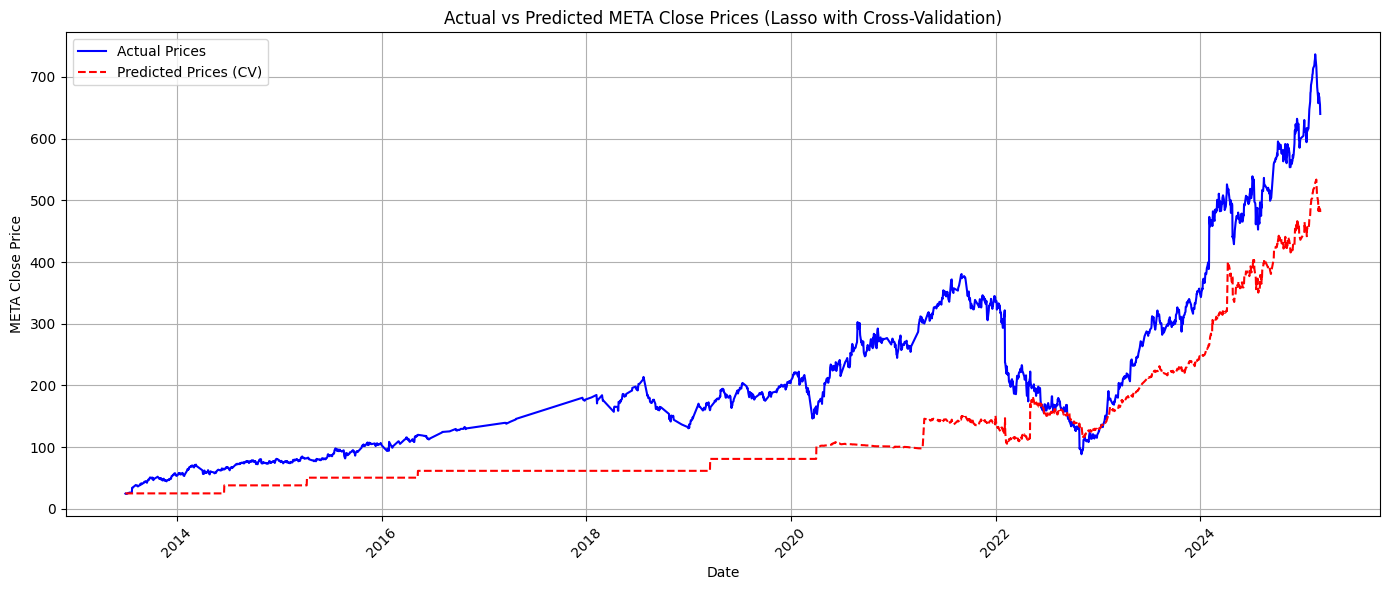

In [36]:
#plotting a graph of the training data
lasso_results_df = pd.DataFrame({
    'Date': all_dates,
    'Actual': lasso_actuals,
    'Predicted': lasso_preds
})

plt.figure(figsize=(14, 6))
sns.lineplot(data=lasso_results_df, x='Date', y='Actual', label='Actual Prices', color='blue')
sns.lineplot(data=lasso_results_df, x='Date', y='Predicted', label='Predicted Prices (CV)', color='red', linestyle='--')

plt.xlabel("Date")
plt.ylabel("META Close Price")
plt.title("Actual vs Predicted META Close Prices (Lasso with Cross-Validation)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
last_known = df_lagged.iloc[-1:].copy()
lasso_future_preds = []

#generating the next 15 trading days- will use this for all the models
#getting the last date from your data
last_date = pd.to_datetime(df_lagged['date'].iloc[-1])

#generating the next 15 trading days (no weekends)
future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=15)

#generating the forecast for the next 15 trading days
for i in range(len(future_dates)):
    #extracting only lag feature values
    X_input = last_known[lag_features].iloc[-1:].values
    X_scaled = scaler_X.transform(X_input)

    #prediciting the next scaled price
    next_scaled_pred = final_lasso.predict(X_scaled)[0]
    #transforming the scaled y values back 
    next_pred = max(0, scaler_y.inverse_transform([[next_scaled_pred]])[0, 0])
    #adding the forecasts to a list
    lasso_future_preds.append(next_pred)

    #generating the next row of prices
    next_row = last_known.iloc[-1:].copy()

    #shifting the target lags down for each day in the forecast
    for lag in range(7, 1, -1):
        next_row[f'{target}_lag_{lag}'] = next_row[f'{target}_lag_{lag - 1}']
    next_row[f'{target}_lag_1'] = next_pred  # insert new prediction

    #shifting the external features for each day in the forecast
    for feature in ['inflationRate', 'Gold_price', 'Silver_price',
                    'META_stock_news_sentiment', 'NVDA_stock_news_sentiment']:
        max_lag = 60 if feature == 'inflationRate' else (
            7 if feature in ['Gold_price', 'NVDA_stock_news_sentiment'] else 5)
        for lag in range(max_lag, 1, -1):
            next_row[f'{feature}_lag_{lag}'] = next_row[f'{feature}_lag_{lag - 1}']
        next_row[f'{feature}_lag_1'] = next_row[f'{feature}_lag_1']  # keep static or inject noise

    #appending row to last_known for next iteration
    last_known = pd.concat([last_known, next_row], ignore_index=True)

    # DEBUG PRINT
    #print(f"Day {i+1} lags:", [next_row[f'{target}_lag_{j}'] for j in range(1, 8)])

    last_known = pd.concat([last_known, next_row.tail(1)], ignore_index=True)


C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skl

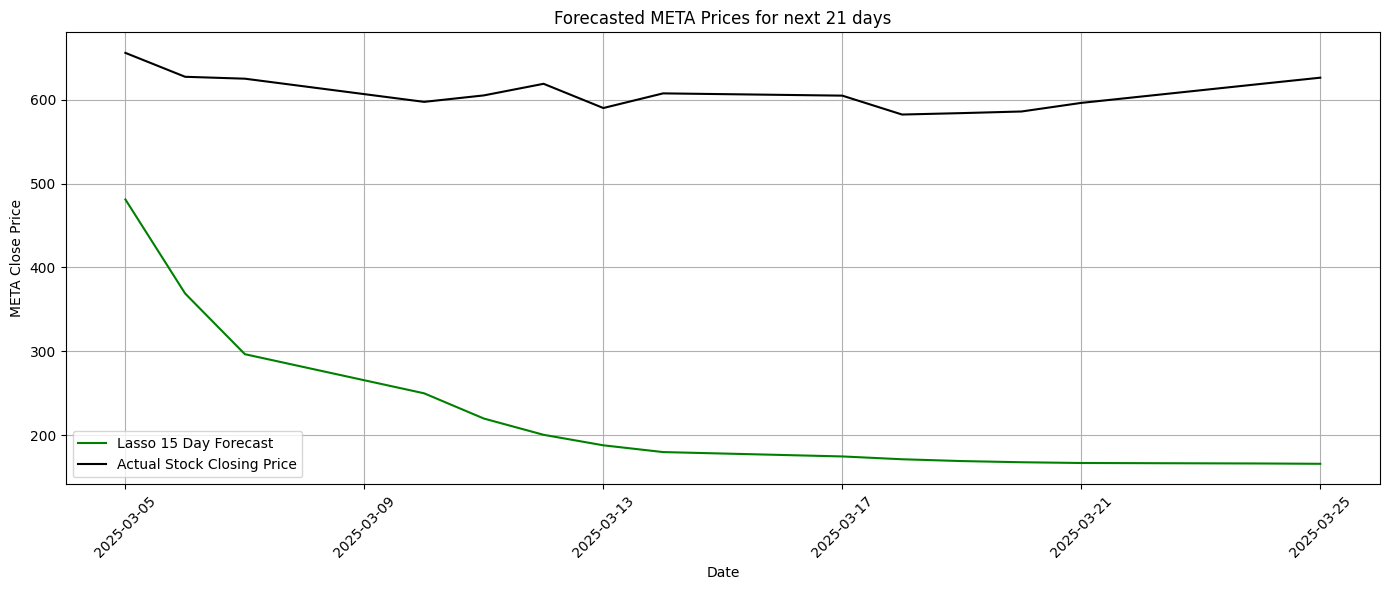

In [45]:
# Create forecast DataFrame
lasso_forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecasted Price': lasso_future_preds
})

# Combine with historical data (CV results)
plt.figure(figsize=(14, 6))
# sns.lineplot(data=lasso_forecast_df, x='Date', y='Forecasted Price', label='15-Day Forecast', color='green')
# sns.lineplot(data=lasso_forecast_df, x='Date', y='Actual Price', label='Real META Price')
plt.plot(lasso_forecast_df['Date'], lasso_forecast_df['Forecasted Price'], label=f'Lasso 15 Day Forecast', color='green')
plt.plot(meta_real['date'], meta_real['META_adjClose'], label = 'Actual Stock Closing Price', color = 'black')
plt.xlabel("Date")
plt.ylabel("META Close Price")
plt.title("Forecasted META Prices for next 21 days")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
#finding the Pearson and Spearman Cooefficents to see how well the model is forecasting and rmse
lasso_pearson_corr, _ = pearsonr(lasso_future_preds, close_real)
lasso_spearman_corr, _= spearmanr(lasso_future_preds, close_real)
lasso_rmse = np.sqrt(mean_squared_error(lasso_future_preds, close_real))

print(f"Lasso Pearson Correlation: {lasso_pearson_corr:.4f}")
print(f"Lasso Spearman Correlation: {lasso_spearman_corr:.4f}")
print(f"Lasso RMSE: {lasso_rmse:.4f}")

Lasso Pearson Correlation: 0.7440
Lasso Spearman Correlation: 0.4286
Lasso RMSE: 391.4042


## Model 2: LSTM

In [64]:
from sklearn.preprocessing import MinMaxScaler

#lag features (and optionally external features)
features = [col for col in df_lagged.columns if 'lag' in col]
X = df_lagged[features].values
y = df_lagged['META_adjClose'].values

#scaling features
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

#reshaping the x values into (samples, timesteps, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))  # 1 timestep


In [65]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Dropout

#creating the lstm model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, input_shape=(X_reshaped.shape[1], X_reshaped.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

#training the model on the data set
lstm_model.fit(X_reshaped, y_scaled, epochs=20, batch_size=32)

C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0379
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0019
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.9781e-04
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.4836e-04
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8256e-04
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9733e-04
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5390e-04
Epoch 8/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2912e-04
Epoch 9/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1514e-04
Epoch 10/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0709e-04
Epoch 11/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0224e-04
Epoch 12/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9868e-04
Epoch 13/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9631e-04
Epoch 14/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9619e-04
Epoch 15/20
69/69 ━━━━━━━━━━━━━━━━━━━

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


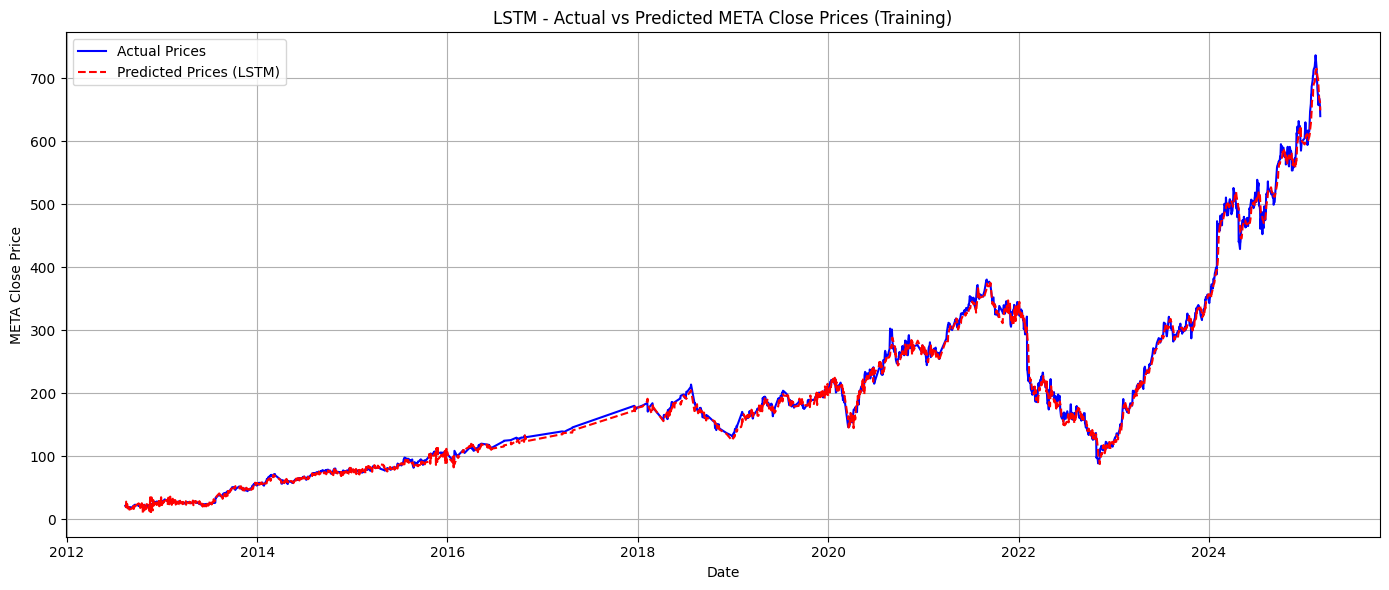

In [66]:
#predicting on training data
train_preds_scaled = lstm_model.predict(X_reshaped)
train_preds = scaler_y.inverse_transform(train_preds_scaled).ravel()
y_actual = scaler_y.inverse_transform(y_scaled.reshape(-1, 1)).ravel()

#plotting the training graph
plt.figure(figsize=(14, 6))
plt.plot(dates, y_actual, label='Actual Prices', color='blue')
plt.plot(dates, train_preds, label='Predicted Prices (LSTM)', color='red', linestyle='--')
plt.title('LSTM - Actual vs Predicted META Close Prices (Training)')
plt.xlabel('Date')
plt.ylabel('META Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [67]:
#doing the forecasting
last_input = X_scaled[-1:].copy()
lstm_future_preds_scaled = []

#forecasting the next 15 trading days
for _ in range(len(future_dates)):
    input_seq = last_input.reshape((1, 1, X_scaled.shape[1]))  
    #using the lstm to do the forecasting
    next_scaled_pred = lstm_model.predict(input_seq)[0][0]
    lstm_future_preds_scaled.append(next_scaled_pred)

    #shifting and updating the lags
    new_lag_input = np.roll(last_input, shift=1)
    #assumes target is at col 0
    new_lag_input[0, 0] = next_scaled_pred 
    last_input = new_lag_input


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


In [68]:
#unscaling the y values
lstm_future_preds = scaler_y.inverse_transform(np.array(lstm_future_preds_scaled).reshape(-1, 1)).ravel()

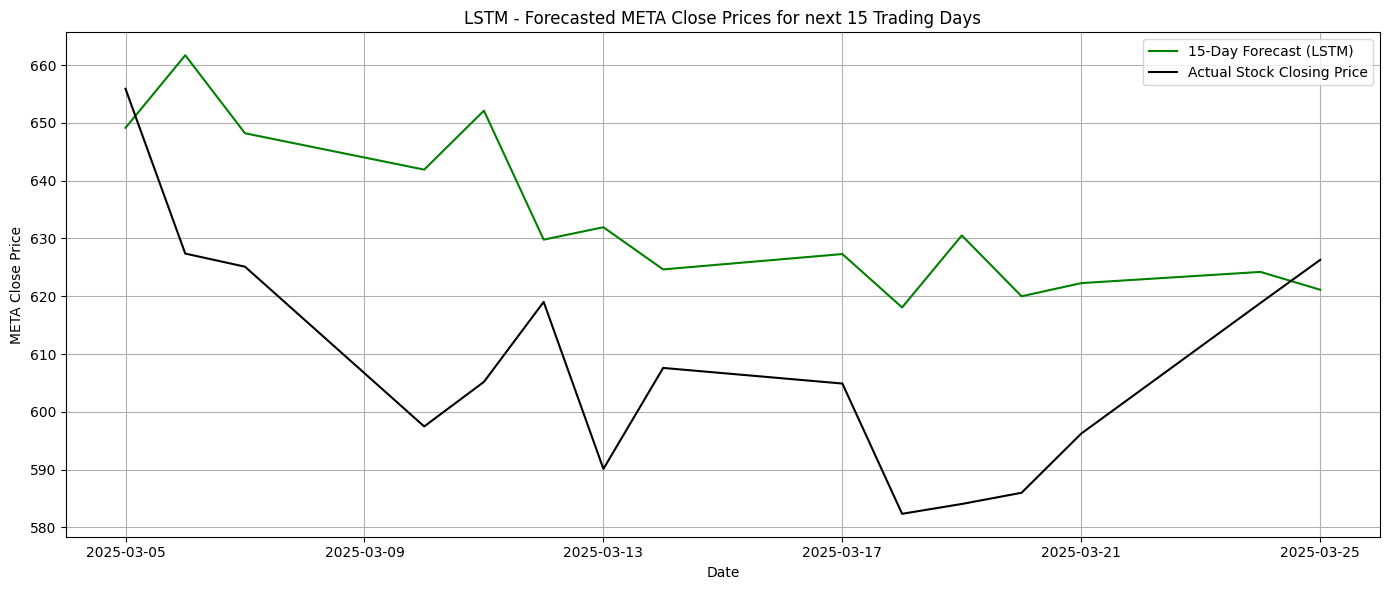

In [69]:

#plot future forecast with the real prices from those days
plt.figure(figsize=(14, 6))
plt.plot(future_dates, lstm_future_preds, label='15-Day Forecast (LSTM)', color='green')
plt.plot(meta_real['date'], meta_real['META_adjClose'], label = 'Actual Stock Closing Price', color = 'black')
plt.title('LSTM - Forecasted META Close Prices for next 15 Trading Days')
plt.xlabel('Date')
plt.ylabel('META Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [70]:
lstm_pearson_corr, _ = pearsonr(lstm_future_preds, close_real)
lstm_spearman_corr, _= spearmanr(lstm_future_preds, close_real)

print(f"LSTM Pearson Correlation: {lstm_pearson_corr:.4f}")
print(f"LSTM Spearman Correlation: {lstm_spearman_corr:.4f}")

LSTM Pearson Correlation: 0.5095
LSTM Spearman Correlation: 0.4714


## Model 3- Bi-LSTM

In [71]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional

In [ ]:
#bi-lstm model
bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(units=32), input_shape=(X_reshaped.shape[1], X_reshaped.shape[2])))
bilstm_model.add(Dense(1))
bilstm_model.compile(optimizer='adam', loss='mean_squared_error')

#training the model on the data set
bilstm_model.fit(X_reshaped, y_scaled, epochs=50, batch_size=32)

C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0147
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8562e-04
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7588e-04
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.1549e-04
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.6743e-04
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5579e-04
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3894e-04
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1678e-04
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9841e-04
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8945e-04
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8731e-04
Epoch 12/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8722e-04
Epoch 13/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.8666e-04
Epoch 14/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8547e-04
Epoch 15/50
69/69 ━━━━━━━━━━━━━━━

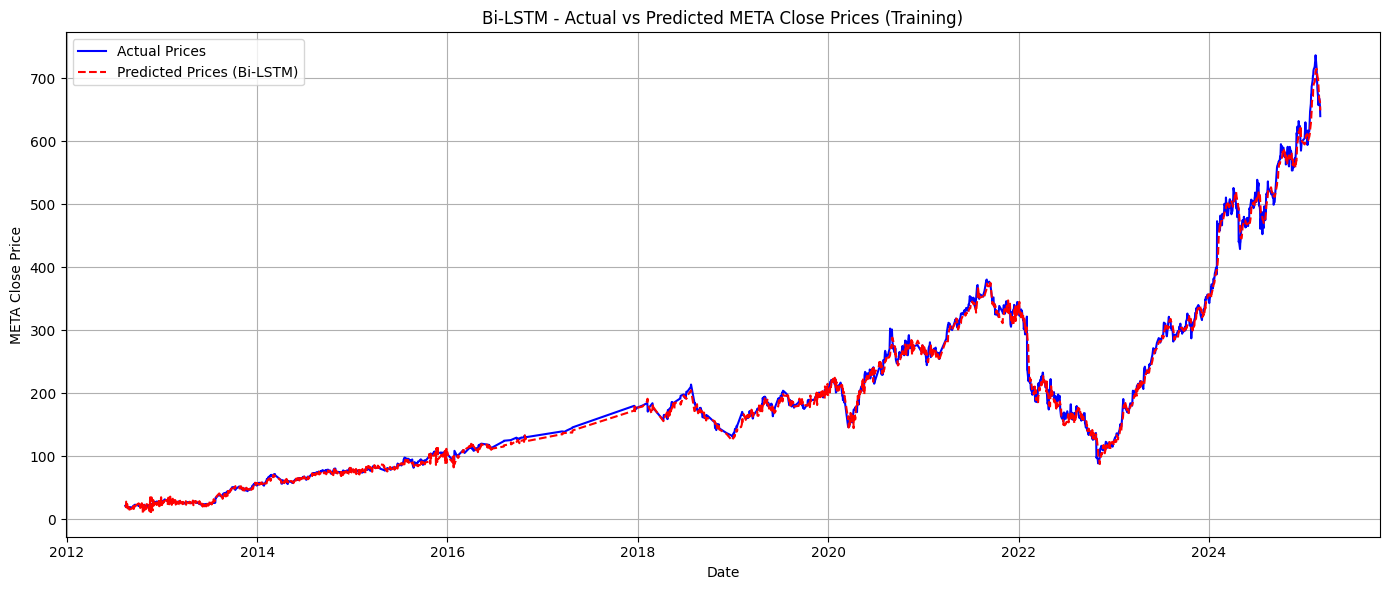

In [ ]:
#inverse transform to get actual prices 
y_actual = scaler_y.inverse_transform(y_scaled.reshape(-1, 1)).ravel()
train_preds = scaler_y.inverse_transform(train_preds_scaled).ravel()

#Training Plot
plt.figure(figsize=(14, 6))
plt.plot(dates, y_actual, label='Actual Prices', color='blue')
plt.plot(dates, train_preds, label='Predicted Prices (Bi-LSTM)', color='red', linestyle='--')
plt.title('Bi-LSTM - Actual vs Predicted META Close Prices (Training)')
plt.xlabel('Date')
plt.ylabel('META Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [81]:
#doing the forecasting 
last_input = X_scaled[-1:].copy()
#empty list to store the future stock prices
bilstm_future_preds_scaled = []

for _ in range(len(future_dates)):
    input_seq = last_input.reshape((1, 1, X_scaled.shape[1]))  # shape = (1, 1, features)
    next_scaled_pred = bilstm_model.predict(input_seq)[0][0]
    bilstm_future_preds_scaled.append(next_scaled_pred)

    #shifting and updating lags
    new_lag_input = np.roll(last_input, shift=1)
    new_lag_input[0, 0] = next_scaled_pred  # assume target is at col 0
    last_input = new_lag_input

#unscaling the y values
bilstm_future_preds = scaler_y.inverse_transform(np.array(bilstm_future_preds_scaled).reshape(-1, 1)).ravel()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


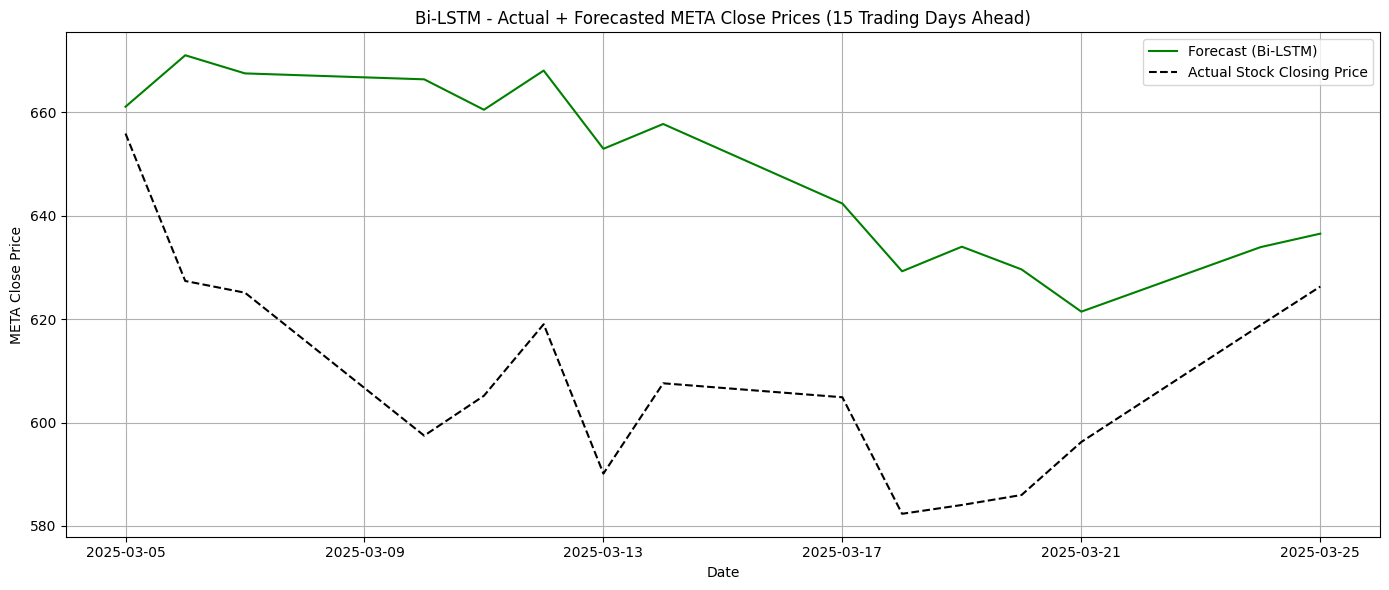

In [82]:
#plot of the forecast vs. the real values
plt.figure(figsize=(14, 6))
plt.plot(future_dates, bilstm_future_preds, label='Forecast (Bi-LSTM)', color='green')
plt.plot(meta_real['date'], meta_real['META_adjClose'], label = 'Actual Stock Closing Price', color = 'black', linestyle = '--')
plt.title('Bi-LSTM - Actual + Forecasted META Close Prices (15 Trading Days Ahead)')
plt.xlabel('Date')
plt.ylabel('META Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [85]:
#checking the pearson and spearman correlations 
bistm_pearson_corr, _ = pearsonr(bilstm_future_preds, close_real)
bilstm_spearman_corr, _= spearmanr(bilstm_future_preds, close_real)
bilstm_rmse = np.sqrt(mean_squared_error(bilstm_future_preds, close_real))

print(f"BiLSTM Pearson Correlation: {bistm_pearson_corr:.4f}")
print(f"BiLSTM Spearman Correlation: {bilstm_spearman_corr:.4f}")
print(f"Bi-LSTM RMSE: {bilstm_rmse:.4f}")

BiLSTM Pearson Correlation: 0.5127
BiLSTM Spearman Correlation: 0.6536
Bi-LSTM RMSE: 44.2574


## Model 4: SARIMAX

In [125]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sar_y = pd.to_numeric(meta_data['META_adjClose'], errors='coerce')
sar_y = sar_y.dropna()

#choosing exogenous variables
exog_features = ['technologyChangesPercentage',
    'Gold_price',
    'Silver_price',
    'JPYUSD_close',
    'EURUSD_close',
    'pe',
    'ema', 'williams',
    'META_stock_news_sentiment',
    'META_press_release_sentiment',
    'NVDA_adjClose',
    'NVDA_stock_news_sentiment',
    'NVDA_press_release_sentiment']

X_exog = meta_data[exog_features].copy()

#mapping sentiment strings to numbers
sentiment_map = {
    'very_negative': -1,
    'weakly_negative': -0.5,
    'neutral': 0,
    'weakly_positive': 0.5,
    'very_positive': 2
}

#applying the sentiment map values to the sentiment columns
for col in X_exog.columns:
    if 'sentiment' in col:
        X_exog[col] = X_exog[col].map(sentiment_map)

#convert all to numeric (in case mapping failed or there are still objects)
X_exog = X_exog.apply(pd.to_numeric, errors='coerce')

#filling in any missing values
X_exog = X_exog.fillna(method='ffill').fillna(method='bfill')

X_exog = X_exog.loc[sar_y.index]
assert len(X_exog) == len(sar_y)


C:\Users\mckay\AppData\Local\Temp\ipykernel_8788\1442246849.py:40: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_exog = X_exog.fillna(method='ffill').fillna(method='bfill')


In [126]:
#training the SARIMAX model
sar_model = SARIMAX(
    sar_y,
    exog=X_exog,
    order=(2, 1, 2),
    seasonal_order=(1, 0, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sar_results = sar_model.fit(disp=False)

C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


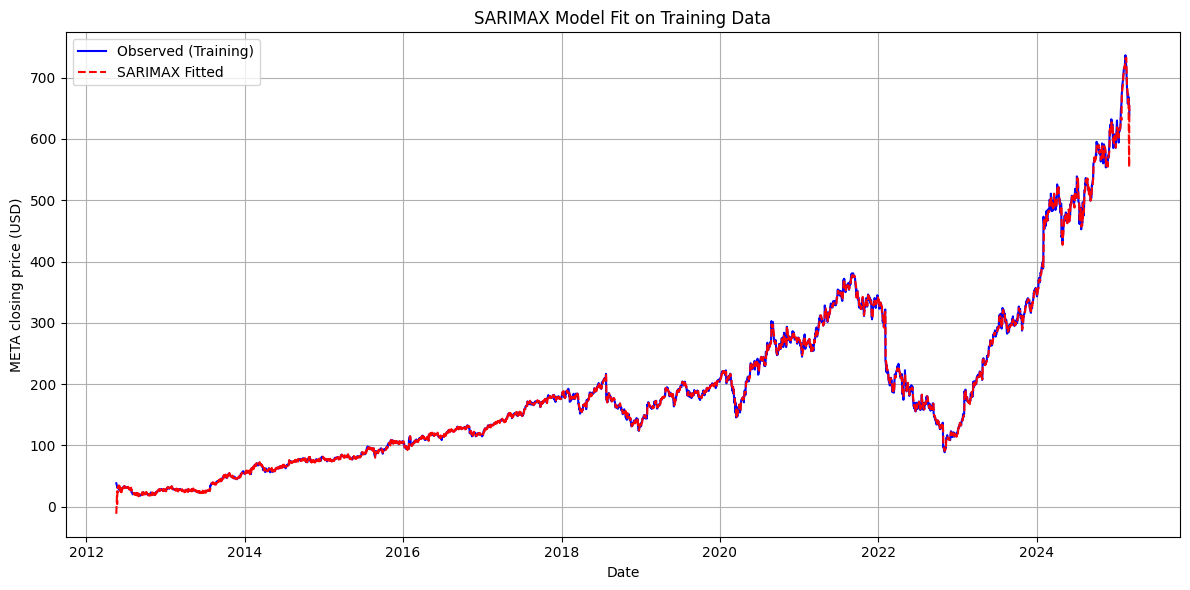

In [130]:
#training results 
fitted_values = sar_results.fittedvalues

#plotting the training results
plt.figure(figsize=(12, 6))
plt.plot(meta_data['date'], sar_y, label='Observed (Training)', color='blue')
plt.plot(meta_data['date'], fitted_values, label='SARIMAX Fitted', color='red', linestyle='--')
plt.title("SARIMAX Model Fit on Training Data")
plt.xlabel("Date")
plt.ylabel("META closing price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [127]:
#creating future exogenous input for the forecasting 
last_known = X_exog.iloc[-1]
sar_future_exog = pd.DataFrame(
    {col: [last_known[col]] * len(future_dates) for col in X_exog.columns},
    index=future_dates
)

#forecasting 15 future points
sar_forecast = sar_results.get_forecast(steps=len(future_dates), exog=sar_future_exog)
sar_forecast_mean = sar_forecast.predicted_mean


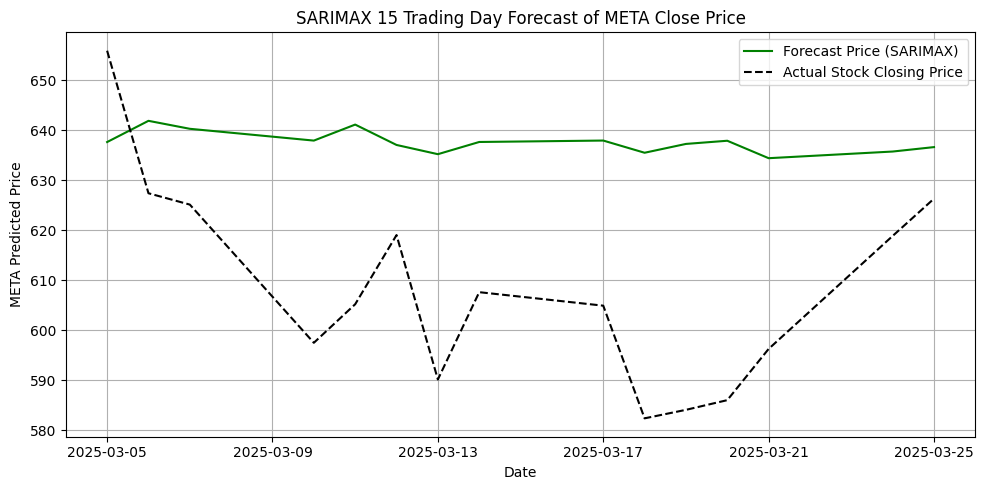

In [128]:
#plotting the forecasting results vs. the real 
plt.figure(figsize=(10, 5))
plt.plot(future_dates, sar_forecast_mean, label='Forecast Price (SARIMAX)', color='green')
plt.plot(meta_real['date'], meta_real['META_adjClose'], label='Actual Stock Closing Price', linestyle='--', color='black')
plt.title('SARIMAX 15 Trading Day Forecast of META Close Price')
plt.xlabel('Date')
plt.ylabel('META Predicted Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [129]:
#checking the pearson and spearman correlations 
sar_pearson_corr, _ = pearsonr(sar_forecast_mean, close_real)
sar_spearman_corr, _= spearmanr(sar_forecast_mean, close_real)
sar_rmse = np.sqrt(mean_squared_error(sar_forecast_mean, close_real))

print(f"SARIMAX Pearson Correlation: {bistm_pearson_corr:.4f}")
print(f"SARIMAX Spearman Correlation: {bilstm_spearman_corr:.4f}")
print(f"SARIMAX RMSE: {bilstm_rmse:.4f}")

SARIMAX Pearson Correlation: 0.5127
SARIMAX Spearman Correlation: 0.6536
SARIMAX RMSE: 44.2574
